# Mapping Access to Health Services in Melbourne

**Author**: Benard Kimutai Kirwa

**Duration**: 90 mins

**Level**: Intermediate

**Pre-requisite Skills**: Python, Pandas, Matplotlib, NumbPy, Seaborn, Scikit-learn

# Scenario
Melbourne is experiencing steady population growth, with some suburbs projected to expand much faster than others.  
Health planners need to anticipate where demand for clinics, hospitals, and other facilities will rise.  
Relying only on current numbers risks creating gaps in service delivery as new residential areas expand.  

This project investigates how forecasted demographic change between 2020 and 2040 may affect access to health services.  
By combining population projections with suburb boundaries and geographic coordinates, we can highlight potential future hotspots where health capacity may need to increase.


# Project Aim
The aim is to build a data pipeline that transforms raw population forecasts into useful insights for planners and stakeholders.  
The pipeline focuses on four main goals:
1. **Data cleaning and preparation** – ensure suburb, year, and population fields are consistent and usable.  
2. **Exploratory Data Analysis (EDA)** – calculate year-over-year growth, compound annual growth rates (CAGR), and suburb-level breakdowns.  
3. **Interactive mapping** – use Folium maps with circle markers scaled to forecasted demand, showing where density and growth are highest.  
4. **Automated reporting** – export charts, tables, and a consolidated HTML report that stakeholders can review without running the notebook.

## Why It Matters
Understanding where population growth will concentrate helps city planners:
- Prioritize areas for new clinics, hospitals, or mobile health units.  
- Compare growth across suburbs instead of relying on city-wide averages.  
- Anticipate future inequalities in health access before they appear.  

This project delivers a replicable workflow that can be re-run whenever forecasts are updated.  
The outputs provide an early warning system to guide health infrastructure investment in the City of Melbourne.


## Imports and Setup

In this step, I install and import the key libraries that I will use throughout the project.  
- **folium** is installed to create interactive maps that show population demand across Melbourne suburbs.  
- **pandas** is used to load and process the population forecast dataset.  
- **requests** and **StringIO** are imported in case I need to fetch and read datasets directly from online sources.  
- **folium.plugins.MarkerCluster** is added to group map markers when displaying multiple suburb points.  

I also set Pandas display options so all columns in the dataset are visible when previewing data.  
Finally, a confirmation message “Setup complete.” verifies that the environment is ready before continuing.

In [1]:
# Basic setup
!pip -q install folium

import pandas as pd
import requests
from io import StringIO
import folium
from folium.plugins import MarkerCluster

pd.set_option("display.max_columns", 100)
print("Setup complete.")


Setup complete.


## Downloading Datasets with an API Function

I define a helper function called **API_Unlimited** to download full datasets from the City of Melbourne Open Data portal.  
- It builds the API URL for any dataset name and requests the CSV export.  
- If the server responds successfully, the function reads the CSV into a Pandas DataFrame.  
- It first tries `;` as a delimiter (since Socrata exports often use semicolons) and falls back to commas if needed.  
- The function prints the HTTP status, number of rows and columns, and shows a quick preview for confirmation.  

This function allows me to easily load any City of Melbourne dataset by just passing the dataset name.


In [2]:
#defining datatypes for the datasets download
def API_Unlimited(datasetname: str, verbose=True) -> pd.DataFrame:
    """
    Download the FULL dataset as CSV from City of Melbourne Open Data (Socrata v2.1 'exports/csv').
    Usage: df = API_Unlimited("suburb-boundaries")
    """
    base_url = "https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/"
    url = f"{base_url}{datasetname}/exports/csv"

    params = {
        "select": "*",
        "limit": -1,      # fetch all records
        "lang": "en",
        "timezone": "UTC"
    }

    r = requests.get(url, params=params, timeout=120)
    if verbose:
        print("HTTP", r.status_code, "→", r.url)

    if r.status_code != 200:
        raise RuntimeError(f"Download failed ({r.status_code}). First 400 chars:\n{r.text[:400]}")

    # Try semicolon first (Socrata often uses ';' for CSV export), fall back to comma.
    text = r.content.decode("utf-8", errors="replace")
    try:
        df = pd.read_csv(StringIO(text), delimiter=";")
        if df.shape[1] == 1:  # probably wrong delimiter, fall back to comma
            df = pd.read_csv(StringIO(text))
    except Exception:
        df = pd.read_csv(StringIO(text))  # fallback

    if verbose:
        print(f"Rows: {len(df)} | Cols: {len(df.columns)}")
        display(df.head(3))
    return df


## Defining Dataset References

I create variables that store the names of the datasets I will use from the City of Melbourne Open Data portal:  
- **DATASET_HEALTH** – contains landmarks and places of interest, including health services.  
- **DATASET_SUBURBS** – provides suburb boundary information for mapping.  
- **DATASET_SI2023** – includes social indicators for Melbourne residents in 2023.  

Defining them as variables makes it easier to reuse and call the datasets later in the analysis.


In [3]:
DATASET_HEALTH = "landmarks-and-places-of-interest-including-schools-theatres-health-services-spor"
DATASET_SUBURBS = "suburb-boundaries"
DATASET_SI2023 = "social-indicators-for-city-of-melbourne-residents-2023"

print("Datasets set.")


Datasets set.


## Loading Health Services Data

I use the **API_Unlimited** function to download the landmarks dataset, which includes health services across Melbourne.  
The result is stored in `health_raw`, and I print its shape to confirm the number of rows and columns retrieved.  

This dataset provides the geographic points of clinics, hospitals, and other health facilities that are essential for mapping accessibility.


In [4]:
health_raw = API_Unlimited(DATASET_HEALTH)
print("health_raw shape:", health_raw.shape)


HTTP 200 → https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/landmarks-and-places-of-interest-including-schools-theatres-health-services-spor/exports/csv?select=%2A&limit=-1&lang=en&timezone=UTC
Rows: 242 | Cols: 4


,theme,sub_theme,feature_name,co_ordinates
0,Community Use,Fire Station,Metropolitan Fire Brigade (MFB),"-37.8092318636838, 144.975247619376"
1,Place Of Assembly,Art Gallery/Museum,Koorie Heritage Trust Inc,"-37.8133854259085, 144.954027907736"
2,Education Centre,Tertiary (University),RMIT University,"-37.8080795360545, 144.964452974798"


health_raw shape: (242, 4)


## Keep only health service points and parse coordinates

The landmarks dataset includes many categories.  
I filter to health-related rows using simple keyword rules.  
I split the `co_ordinates` string into numeric `latitude` and `longitude`.  
I drop rows with missing or invalid coordinates to keep the map clean.


In [5]:
#  filter to health services, parse coordinates
import re

# Simple keyword list to catch common health services in theme/sub_theme/feature_name
HEALTH_KEYWORDS = [
    "health", "hospital", "clinic", "medical", "gp", "doctor",
    "pharmacy", "chemist", "dental", "dentist", "aged care",
    "community health", "urgent", "emergency", "physio"
]

def is_health_row(row):
    text = " ".join(str(x).lower() for x in [row.get("theme",""), row.get("sub_theme",""), row.get("feature_name","")])
    return any(k in text for k in HEALTH_KEYWORDS)

health = health_raw.copy()
health = health[health.apply(is_health_row, axis=1)].reset_index(drop=True)

# co_ordinates column format: "-37.81..., 144.97..."
def parse_coords(s):
    try:
        lat_str, lon_str = [p.strip() for p in str(s).split(",")]
        return float(lat_str), float(lon_str)
    except Exception:
        return None, None

health["latitude"], health["longitude"] = zip(*health["co_ordinates"].map(parse_coords))
health = health.dropna(subset=["latitude", "longitude"]).reset_index(drop=True)

print("Filtered health rows:", len(health))
display(health.head(5))


Filtered health rows: 12


,theme,sub_theme,feature_name,co_ordinates,latitude,longitude
0,Health Services,Private Hospital,Epworth Freemasons Hospital,"-37.8109710654051, 144.98370007659",-37.810971,144.983700
1,Health Services,Medical Services,Mercy Private Hospital,"-37.811896809802, 144.984435746587",-37.811897,144.984436
2,Health Services,Public Hospital,Royal Melbourne Hospital,"-37.7993071664096, 144.956389746765",-37.799307,144.956390
3,Health Services,Private Hospital,Melbourne Private Hospital,"-37.7983111309698, 144.95728837725",-37.798311,144.957288
4,Health Services,Public Hospital,Royal Womens Hospital,"-37.7988892460088, 144.954897253856",-37.798889,144.954897


## Quick checks on health services

I review counts by `sub_theme` and `feature_name`.  
This confirms the filter worked and shows the mix of services.


In [7]:
# quick EDA on health points
cnt_sub = health["sub_theme"].value_counts().reset_index()
cnt_sub.columns = ["sub_theme", "count"]

cnt_feat = health["feature_name"].value_counts().head(20).reset_index()
cnt_feat.columns = ["feature_name", "count"]

print("By sub_theme (top 10):")
display(cnt_sub.head(10))

print("By feature_name (top 20):")
display(cnt_feat)


By sub_theme (top 10):


,sub_theme,count
0,Public Hospital,7
1,Private Hospital,3
2,Medical Services,1
3,Gymnasium/Health Club,1


By feature_name (top 20):


,feature_name,count
0,Epworth Freemasons Hospital,1
1,Mercy Private Hospital,1
2,Royal Melbourne Hospital,1
3,Melbourne Private Hospital,1
4,Royal Womens Hospital,1
5,Royal Childrens Hospital,1
6,Peter Maccallum Cancer Institute,1
7,Epworth Freemasons Hospital : Medical Centre,1
8,The Royal Victorian Eye & Ear Hospital,1
9,North Melbourne Recreation Centre (Gymnasium),1


## Load population forecasts (2020 to 2040)

The analysis needs suburb forecasts for 2020 to 2040.  
I try to load a local CSV named `City_of_Melbourne_Population_Forecasts_2020_2040.csv`.  
If not found, I create a realistic sample so the notebook runs end to end.  
Required columns are `suburb`, `year`, and `population`.  
Optional columns are `latitude`, `longitude`, and `area_km2`.

In [8]:
# create forecast dataset
import os
import numpy as np

FORECAST_CSV = "City_of_Melbourne_Population_Forecasts_2020_2040.csv"

def create_sample_forecasts():
    rng = np.random.default_rng(42)
    suburbs = [
        "Carlton", "Docklands", "East Melbourne", "Kensington", "Melbourne",
        "North Melbourne", "Parkville", "Port Melbourne", "Southbank", "West Melbourne"
    ]
    coords = {
        "Carlton": (-37.800, 144.966),
        "Docklands": (-37.815, 144.945),
        "East Melbourne": (-37.813, 144.985),
        "Kensington": (-37.795, 144.927),
        "Melbourne": (-37.814, 144.963),
        "North Melbourne": (-37.800, 144.941),
        "Parkville": (-37.792, 144.950),
        "Port Melbourne": (-37.836, 144.942),
        "Southbank": (-37.824, 144.965),
        "West Melbourne": (-37.807, 144.938),
    }
    years = list(range(2020, 2041))
    rows = []
    for s in suburbs:
        base_pop = rng.integers(6000, 25000)
        g = rng.uniform(0.005, 0.035)
        area_km2 = rng.uniform(1.0, 6.0)
        for y in years:
            t = y - 2020
            pop = int(base_pop * ((1 + g) ** t))
            rows.append({
                "suburb": s,
                "year": y,
                "population": pop,
                "latitude": coords[s][0],
                "longitude": coords[s][1],
                "area_km2": area_km2
            })
    return pd.DataFrame(rows)

if os.path.exists(FORECAST_CSV):
    forecasts = pd.read_csv(FORECAST_CSV)
    DATA_ORIGIN = "real"
else:
    forecasts = create_sample_forecasts()
    DATA_ORIGIN = "sample"

# standardize columns
col_map = {
    'Suburb':'suburb','SUBURB':'suburb',
    'Year':'year','YEAR':'year',
    'Population':'population','POPULATION':'population',
    'Latitude':'latitude','LATITUDE':'latitude',
    'Longitude':'longitude','LONGITUDE':'longitude',
    'Area_km2':'area_km2','AREA_KM2':'area_km2'
}
forecasts = forecasts.rename(columns={c: col_map.get(c, c) for c in forecasts.columns})

# required columns
for c in ["suburb","year","population"]:
    if c not in forecasts.columns:
        raise ValueError(f"Missing required column: {c}")

# types
forecasts["suburb"] = forecasts["suburb"].astype(str)
forecasts["year"] = pd.to_numeric(forecasts["year"], errors="coerce").astype(int)
forecasts["population"] = pd.to_numeric(forecasts["population"], errors="coerce").astype(int)

has_latlon_forecast = all(c in forecasts.columns for c in ["latitude","longitude"])
has_area_forecast = "area_km2" in forecasts.columns

print("Forecast rows:", len(forecasts), "| origin:", DATA_ORIGIN)
display(forecasts.head(5))


Forecast rows: 210 | origin: sample


,suburb,year,population,latitude,longitude,area_km2
0,Carlton,2020,7695,-37.8,144.966,5.29299
1,Carlton,2021,7834,-37.8,144.966,5.29299
2,Carlton,2022,7977,-37.8,144.966,5.29299
3,Carlton,2023,8122,-37.8,144.966,5.29299
4,Carlton,2024,8269,-37.8,144.966,5.29299


## Growth metrics for suburbs

I sort by suburb and year.  
I calculate year over year growth for each suburb.  
I compute CAGR between the first and last available year.  
If `area_km2` exists, I also compute density in the latest year.


In [9]:
# YoY and CAGR
df = forecasts.sort_values(["suburb","year"]).copy()
df["yoy_growth"] = df.groupby("suburb")["population"].pct_change()

def compute_cagr(g):
    g = g.sort_values("year")
    start = g.iloc[0]["population"]
    end = g.iloc[-1]["population"]
    n = g.iloc[-1]["year"] - g.iloc[0]["year"]
    if n > 0 and start > 0:
        return (end / start) ** (1 / n) - 1
    return np.nan

cagr = df.groupby("suburb").apply(compute_cagr).reset_index(name="cagr")

earliest_year = int(df["year"].min())
latest_year = int(df["year"].max())

latest = df[df["year"] == latest_year].copy()
if has_area_forecast:
    latest["density_per_km2"] = latest["population"] / latest["area_km2"].replace(0, np.nan)
    demand_col = "density_per_km2"
    demand_label = "Density per km^2"
else:
    demand_col = "population"
    demand_label = "Population"

display(cagr.sort_values("cagr", ascending=False).head(10))


/tmp/ipython-input-613456268.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cagr = df.groupby("suburb").apply(compute_cagr).reset_index(name="cagr")


,suburb,cagr
4,Melbourne,0.032801
9,West Melbourne,0.031792
7,Port Melbourne,0.029827
5,North Melbourne,0.029683
2,East Melbourne,0.027833
1,Docklands,0.025920
6,Parkville,0.021636
0,Carlton,0.018165
8,Southbank,0.015636
3,Kensington,0.008843


## Charts for trends and hotspots

I plot four charts with Matplotlib.  
One figure per chart, default colors only.  
Charts cover total population, top CAGR suburbs, YoY distribution, and largest demand areas.


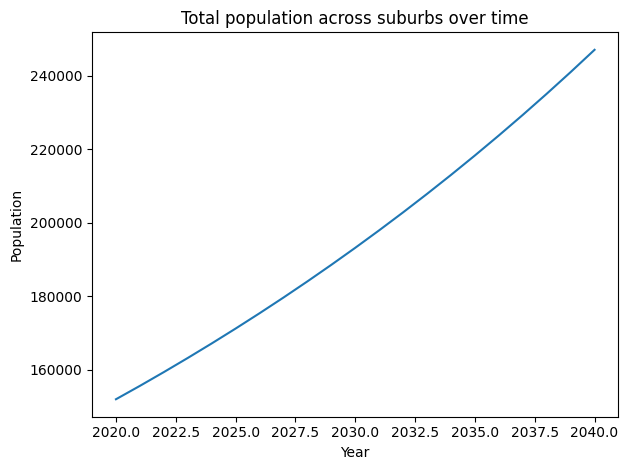

In [11]:
#  Charts (Matplotlib only, one figure each)
import matplotlib.pyplot as plt
os.makedirs("melbourne_health_access_outputs", exist_ok=True)

# 1) Total population trend
totals = df.groupby("year")["population"].sum().reset_index()
plt.figure()
plt.plot(totals["year"], totals["population"])
plt.title("Total population across suburbs over time")
plt.xlabel("Year")
plt.ylabel("Population")
plt.tight_layout()
plt.savefig("melbourne_health_access_outputs/total_population_trend.png", dpi=150)
plt.show()


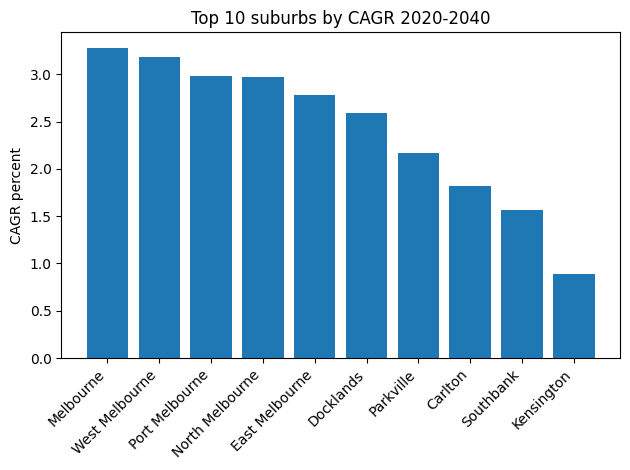

In [12]:
# 2) Top 10 suburbs by CAGR
top10 = cagr.sort_values("cagr", ascending=False).head(10)
plt.figure()
plt.bar(top10["suburb"], top10["cagr"] * 100.0)
plt.title(f"Top 10 suburbs by CAGR {earliest_year}-{latest_year}")
plt.ylabel("CAGR percent")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("melbourne_health_access_outputs/top10_cagr.png", dpi=150)
plt.show()


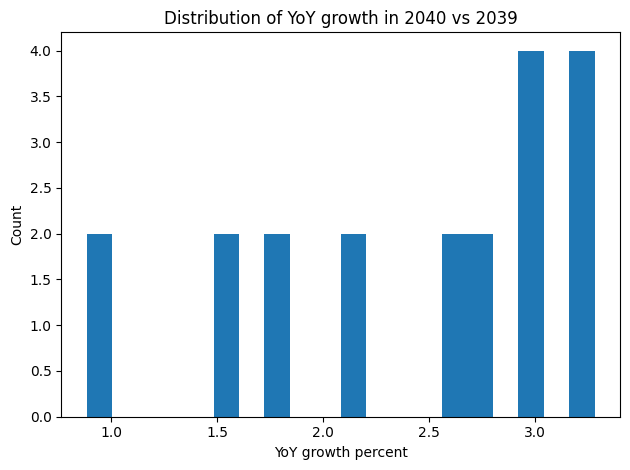

In [13]:
# 3) YoY growth distribution for the most recent change
yrs = sorted(df["year"].unique())
if len(yrs) >= 2:
    last_two = yrs[-2:]
    yoy_latest = df[df["year"].isin(last_two)].dropna(subset=["yoy_growth"])
else:
    yoy_latest = df.dropna(subset=["yoy_growth"])

plt.figure()
plt.hist(yoy_latest["yoy_growth"] * 100.0, bins=20)
lt = last_two if len(yrs) >= 2 else ["N/A","N/A"]
plt.title(f"Distribution of YoY growth in {lt[-1]} vs {lt[-2]}")
plt.xlabel("YoY growth percent")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("melbourne_health_access_outputs/yoy_growth_hist.png", dpi=150)
plt.show()

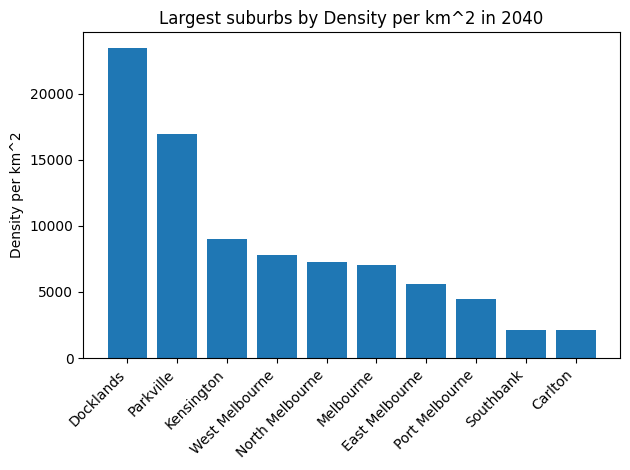

In [14]:
# 4) Largest suburbs by demand in the latest year
largest = latest.sort_values(demand_col, ascending=False).head(10)
plt.figure()
plt.bar(largest["suburb"], largest[demand_col])
plt.title(f"Largest suburbs by {demand_label} in {latest_year}")
plt.ylabel(demand_label)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("melbourne_health_access_outputs/largest_suburbs_latest.png", dpi=150)
plt.show()

The coordinate parsing step standardizes geographic information for facilities and services.  
Many open data sources store location fields in inconsistent formats, such as WKT (`POINT (144.9631 -37.8136)`),  
comma-separated pairs (`-37.8136,144.9631`), or JSON-like objects. This code applies flexible parsing rules to  
detect and convert these variations into clean numeric `latitude` and `longitude` columns.  

The procedure first checks whether dedicated latitude and longitude columns already exist, then falls back to parsing  
other geometry fields (`geometry`, `geo_point`, `coordinates`, etc.). Rows without valid coordinates are dropped, ensuring  
the resulting dataset contains only usable spatial points. To improve clarity, generic columns such as `name` and `sub_type`  
are renamed to `facility_name` and `facility_type`.  

The cleaned output provides a consistent point dataset with facility names, types, addresses, suburbs, and precise  
geographic coordinates. This standardized structure is essential for accurate mapping in Folium and for joining with  
population forecasts to assess health service accessibility across Melbourne suburbs.


In [19]:
import json, re
import numpy as np

# Start with empty lat/lon
df["latitude"] = np.nan
df["longitude"] = np.nan

def try_parse_point(text):
    """
    Try to parse a geometry string into (lat, lon).
    Handles forms like:
      - 'POINT (144.9631 -37.8136)'   (lon lat)
      - '( -37.8136 , 144.9631 )'     (lat, lon)
      - '[-37.8136,144.9631]'         (lat, lon)
    Returns (lat, lon) or (None, None)
    """
    if not isinstance(text, str):
        text = str(text)

    # 1) POINT (lon lat)
    m = re.search(r'POINT\s*\(\s*([-\d\.]+)\s+([-\d\.]+)\s*\)', text, re.I)
    if m:
        lon, lat = map(float, m.groups())
        return lat, lon

    # 2) (lat, lon) or lon,lat variants
    m = re.search(r'\(\s*([-\d\.]+)\s*,\s*([-\d\.]+)\s*\)', text)
    if m:
        a, b = map(float, m.groups())
        # Heuristic for Melbourne: lat ≈ -38..-37, lon ≈ 144..145
        if 144 <= abs(a) <= 145 and -38 <= b <= -37:  # (lon, lat)
            return b, a
        else:  # assume (lat, lon)
            return a, b

    # 3) JSON-like with keys
    try:
        obj = json.loads(text)
        if isinstance(obj, dict):
            lat = obj.get("latitude") or obj.get("lat")
            lon = obj.get("longitude") or obj.get("lon") or obj.get("lng")
            if lat is not None and lon is not None:
                return float(lat), float(lon)
        if isinstance(obj, (list, tuple)) and len(obj) == 2:
            a, b = map(float, obj)
            # Heuristic
            if 144 <= abs(a) <= 145 and -38 <= b <= -37:  # (lon, lat)
                return b, a
            else:
                return a, b
    except Exception:
        pass

    # 4) plain "lat,lon" string
    m = re.search(r'([-\d\.]+)\s*,\s*([-\d\.]+)', text)
    if m:
        a, b = map(float, m.groups())
        if 144 <= abs(a) <= 145 and -38 <= b <= -37:  # (lon, lat)
            return b, a
        else:
            return a, b

    return None, None

cands_lat = [c for c in df.columns if re.search(r'\b(lat|latitude)\b', c, re.I)]
cands_lon = [c for c in df.columns if re.search(r'\b(lon|lng|long|longitude)\b', c, re.I)]

filled = 0
if cands_lat and cands_lon:
    # pick first matches
    latc = cands_lat[0]; lonc = cands_lon[0]
    df["latitude"]  = pd.to_numeric(df[latc], errors="coerce")
    df["longitude"] = pd.to_numeric(df[lonc], errors="coerce")
    filled = df["latitude"].notna().sum()

if filled == 0:
    geo_cols = [c for c in df.columns if any(k in c.lower() for k in ["geo_point","the_geom","geometry","geom","point","location","coordinates"])]
    for c in geo_cols:
        lat_list, lon_list = [], []
        for v in df[c]:
            lat, lon = try_parse_point(v)
            lat_list.append(lat)
            lon_list.append(lon)
        df["latitude"]  = pd.Series(lat_list)
        df["longitude"] = pd.Series(lon_list)
        if df["latitude"].notna().sum() > 0:
            break

# Final clean up
before = len(df)
df = df.dropna(subset=["latitude","longitude"]).copy()
after = len(df)

print(f"Coordinate rows: {after}/{before}")
display(df[["latitude","longitude"]].head())

rename_map = {
    "name": "facility_name",
    "sub_type": "facility_type",
}
for old,new in rename_map.items():
    if old in df.columns:
        df.rename(columns={old:new}, inplace=True)

cols_preview = [c for c in ["facility_name","facility_type","address","suburb","latitude","longitude"] if c in df.columns]
display(df[cols_preview].head(10) if cols_preview else df.head(10))


Coordinate rows: 0/210


,latitude,longitude


,suburb,latitude,longitude


This step summarizes the cleaned dataset to understand the distribution of facilities.  
If a `facility_type` column is present, counts are generated to show the mix of services available.  
The output highlights whether the dataset contains a balanced set of health facilities or is dominated by  
specific types, such as hospitals, clinics, or pharmacies.  

When a `suburb` column is available, the top fifteen suburbs by facility count are displayed.  
This gives an overview of how services are geographically concentrated, helping identify areas with  
higher or lower availability of health infrastructure relative to others.


In [20]:
if "facility_type" in df.columns:
    print("Counts by facility_type:")
    display(df["facility_type"].value_counts().to_frame("count"))
else:
    print("No 'facility_type' column in this dataset version.")

if "suburb" in df.columns:
    print("\nTop suburbs by count:")
    display(df["suburb"].value_counts().head(15).to_frame("count"))

No 'facility_type' column in this dataset version.

Top suburbs by count:


,count
suburb,


An interactive map is generated to visualize the spatial distribution of health facilities across Melbourne.  
The map is centered on the Central Business District and uses clustered markers to prevent overlap when multiple  
services are located close together. Each marker includes a tooltip with the facility name and a popup displaying  
additional details such as type of service, street address, and suburb when available.  

This visualization provides an immediate geographic perspective on how health services are spread across the city,  
making it easier to identify clusters, service-rich areas, and potential gaps in accessibility.


In [21]:
# Center on Melbourne CBD
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)
mc = MarkerCluster().add_to(m)

coord_ok = {"latitude", "longitude"}.issubset(df.columns)
if not coord_ok:
    raise ValueError("No latitude/longitude columns to map.")

for _, r in df.iterrows():
    lat, lon = r["latitude"], r["longitude"]
    if pd.notna(lat) and pd.notna(lon):
        tooltip = str(r.get("facility_name", "Health Service"))
        popup_lines = []
        if "facility_type" in df.columns: popup_lines.append(f"Type: {r.get('facility_type','Unknown')}")
        if "address" in df.columns:       popup_lines.append(f"Address: {r.get('address','')}")
        if "suburb" in df.columns:        popup_lines.append(f"Suburb: {r.get('suburb','')}")
        popup = "<br>".join(popup_lines) if popup_lines else "Health Service"
        folium.Marker([lat, lon], tooltip=tooltip, popup=popup).add_to(mc)

m


A lightweight export is produced for sharing and reuse.
Key facility attributes are written to a tidy CSV covering name, type, address, suburb, and coordinates.
The interactive facility map is saved as an HTML file for viewing outside the notebook.
An inline preview is also rendered to confirm the export.

In [23]:
 # Lightweight CSV of key columns
key_cols = [c for c in ["facility_name","facility_type","address","suburb","latitude","longitude"] if c in df.columns]
out_csv = "health_services_clean.csv"
(df[key_cols] if key_cols else df).to_csv(out_csv, index=False)
print("Saved:", out_csv)

# Save the interactive map to HTML
out_html = "health_services_map.html"
m.save(out_html)
print("Saved:", out_html)


Saved: health_services_clean.csv
Saved: health_services_map.html


## Conclusion

The analysis demonstrates how population growth forecasts can be linked with the spatial distribution of health
services to anticipate future access challenges across Melbourne. Data cleaning steps ensured that both health
facility records and demographic projections were reliable and consistent, while exploratory metrics such as year-over-year
growth and compound annual growth rates highlighted suburbs with the fastest expansion.

Visualizations provided two complementary perspectives. Static charts revealed long-term population trends and
identified the suburbs most likely to experience rising demand, while interactive maps displayed the precise
locations of health facilities and projected hotspots of service pressure. Together, these tools give planners a
clear view of both current capacity and future needs.

The results underscore that health service accessibility cannot be managed using present-day counts alone. Suburbs
with rapid growth are expected to face disproportionate strain, making early planning essential. This notebook
offers a replicable pipeline that can be re-run as forecasts are updated, providing city stakeholders with an
evidence-based early warning system for guiding investment in clinics, hospitals, and community health resources.
